### Development of immunogenicity model

In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from modules.kidera import score_positions, score_sequence

import warnings
warnings.filterwarnings('ignore')

In [2]:
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']

idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Length','Immunogenicity']

idf2["Species"] = idf2.Peptide.str.len()
idf2.columns = ['Peptide', 'MHC', 'Length','Immunogenicity']

idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
idf1 = idf.Peptide.apply(lambda s: score_sequence(s))
idf = pd.concat([idf, idf1], axis=1)
features = ["Length","helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
idf.head()

,Peptide,MHC,Length,Immunogenicity,1,2,3,4,5,6,7,8,9,10
0,KLEDLERDL,HLA-A*02:01,9,1,-0.553333,0.225556,-0.662222,0.470000,-0.696667,-0.690000,0.221111,-0.116667,0.213333,0.608889
1,DLMGYIPLV,HLA-A*02:01,9,1,0.058889,-0.191111,0.085556,-0.528889,0.102222,-0.494444,0.007778,0.080000,-0.042222,0.267778
2,QTVTSTPVQGR,HLA-A*68:01,11,1,0.264545,-0.467273,0.727273,0.424545,0.179091,-0.030909,0.082727,-0.566364,-0.392727,-0.173636
3,TTVYPPSSTAK,HLA-A*03:01,11,1,0.478182,-0.454545,0.299091,0.154545,0.195455,-0.456364,-0.262727,-0.856364,-0.265455,0.077273
4,LITGRLQSL,HLA-A2,9,1,-0.174444,-0.265556,0.405556,-0.023333,-0.333333,-0.600000,0.386667,-0.312222,-0.108889,0.003333


In [3]:
idf = idf.drop(["MHC"], axis=1)
idf.columns = ['Peptide', 'Length','Immunogenicity'] + features[1:]
idf = idf[['Peptide', 'Immunogenicity'] + features]

idf.head()

,Peptide,Immunogenicity,Length,helix.bend.pref,side.chain.size,extended.str.pref,hydrophobicity,double.bend.pref,partial.spec.vol,flat.ext.pref,occurrence.alpha.reg,pK.C,surrounding.hydrop
0,KLEDLERDL,1,9,-0.553333,0.225556,-0.662222,0.470000,-0.696667,-0.690000,0.221111,-0.116667,0.213333,0.608889
1,DLMGYIPLV,1,9,0.058889,-0.191111,0.085556,-0.528889,0.102222,-0.494444,0.007778,0.080000,-0.042222,0.267778
2,QTVTSTPVQGR,1,11,0.264545,-0.467273,0.727273,0.424545,0.179091,-0.030909,0.082727,-0.566364,-0.392727,-0.173636
3,TTVYPPSSTAK,1,11,0.478182,-0.454545,0.299091,0.154545,0.195455,-0.456364,-0.262727,-0.856364,-0.265455,0.077273
4,LITGRLQSL,1,9,-0.174444,-0.265556,0.405556,-0.023333,-0.333333,-0.600000,0.386667,-0.312222,-0.108889,0.003333


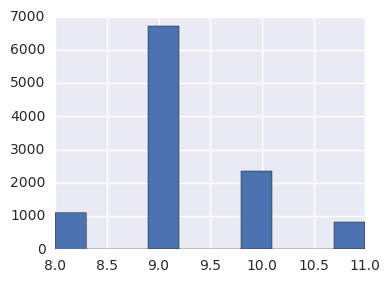

In [23]:
fig = plt.figure(1, figsize=(4, 3))
idf.Length.hist()

In [75]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
# Metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score

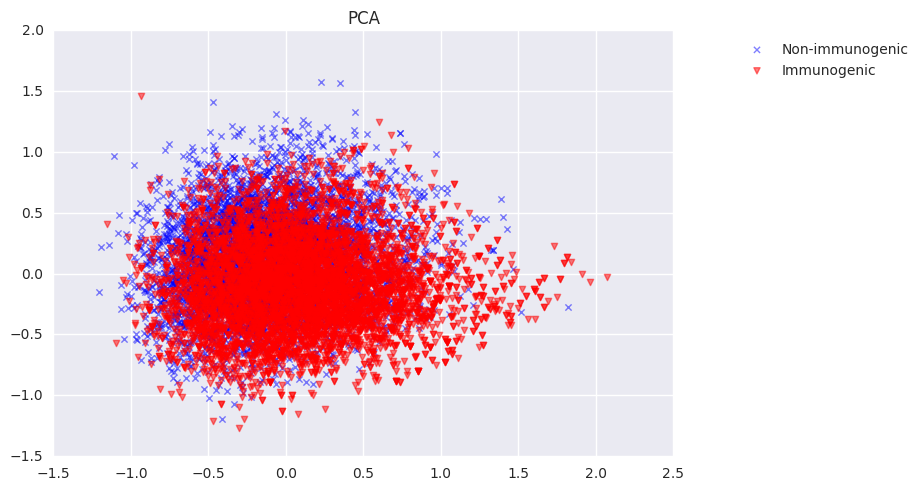

In [6]:
def plot_PCA(X, y):
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)

    fig, ax = plt.subplots()

    ax.scatter(X_pca[np.where(y == 0), 0],
                       X_pca[np.where(y == 0), 1],
                       marker='x', color='b',
                       linewidth='1', alpha=0.5, label='Non-immunogenic')
    ax.scatter(X_pca[np.where(y == 1), 0],
                       X_pca[np.where(y == 1), 1],
                       marker='v', color='r',
                       linewidth='1', alpha=0.5, label='Immunogenic')
    plt.title("PCA")
    plt.legend(bbox_to_anchor=(1.40, 1.0))

plot_PCA(idf[features[1:]], idf["Immunogenicity"])

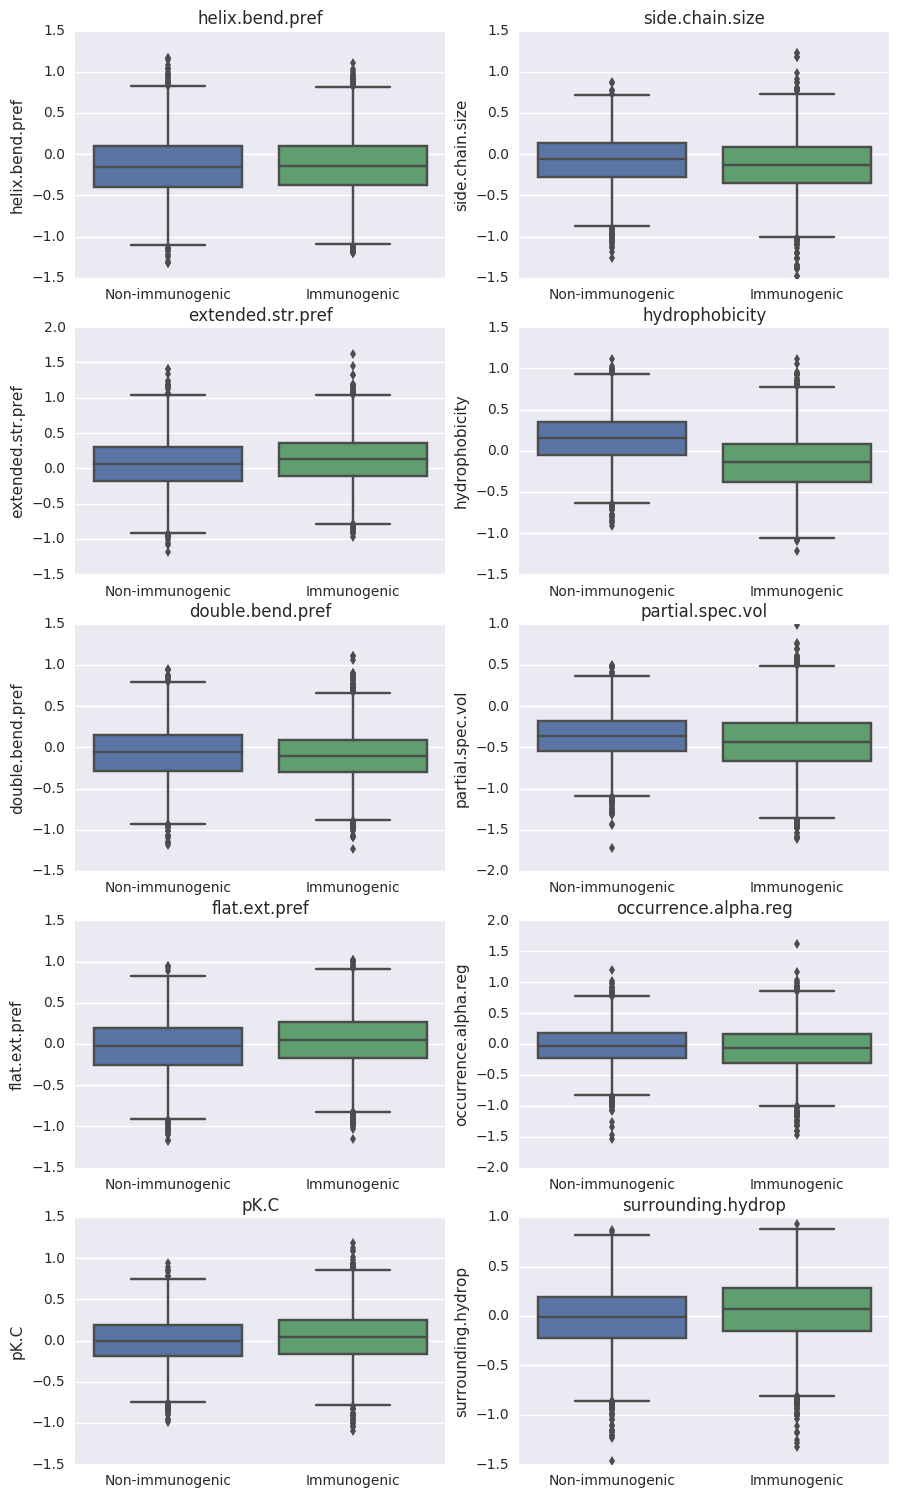

In [34]:
def plot_prop(prop, ax):
    sns.boxplot(x="Immunogenicity", y=prop, data=idf, ax=ax)
    labels = ['Non-immunogenic', 'Immunogenic']
    ax.set_xticklabels(labels)
    ax.set_xlabel("")
    ax.set_title(prop)

props = features[1:]
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(10.5, 18.5)
n = 0
for ax1, ax2 in axs:
    plot_prop(props[n], ax1)
    n+=1
    plot_prop(props[n], ax2)
    n+=1

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(idf[features], idf["Immunogenicity"])))


# Removing length from GaussianMixture model decreases roc auc from 0.49 to 0.44
X_train = idf[features].iloc[train_index,:]
y_train = idf["Immunogenicity"].iloc[train_index]
X_test = idf[features].iloc[test_index,:]
y_test = idf["Immunogenicity"].iloc[test_index]

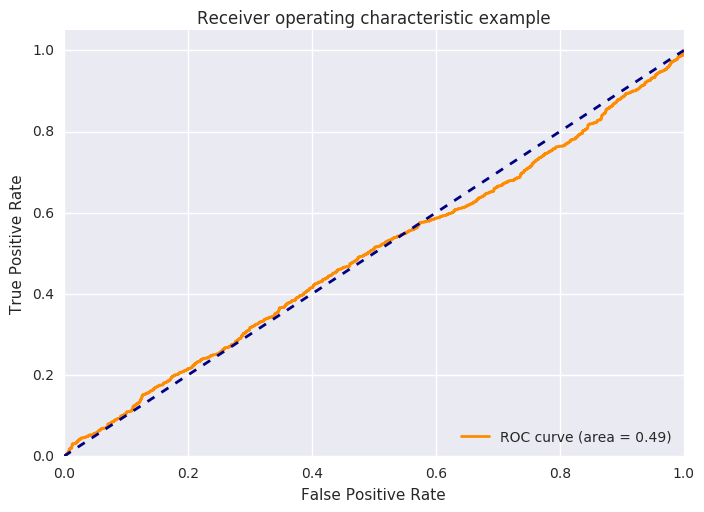

In [12]:
gmm = GaussianMixture(n_components=2, covariance_type='tied',
                              max_iter=100).fit(X_train, y_train)
y_score = gmm.score_samples(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [19]:
idf.columns

Index(['Peptide', 'Immunogenicity', 'Length', 'helix.bend.pref',
       'side.chain.size', 'extended.str.pref', 'hydrophobicity',
       'double.bend.pref', 'partial.spec.vol', 'flat.ext.pref',
       'occurrence.alpha.reg', 'pK.C', 'surrounding.hydrop'],
      dtype='object')

In [25]:
from itertools import combinations
from scipy.stats import pearsonr

for i, j in combinations(features, 2):
    p = pearsonr(idf[i], idf[j])
    if p[0] > 0.25:
        print("{0:<5} {1:^5} {2:>5}".format(i, j, p[0]))

side.chain.size pK.C  0.2550123513855708
hydrophobicity partial.spec.vol 0.34582590034045974


In [26]:
forest = RandomForestClassifier(100, max_features=None, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
feats_imp = pd.DataFrame(forest.feature_importances_,
                        index=features, 
                        columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
feats_imp

,Importance
hydrophobicity,0.332172
flat.ext.pref,0.086212
partial.spec.vol,0.078116
surrounding.hydrop,0.073899
side.chain.size,0.069656
extended.str.pref,0.068084
occurrence.alpha.reg,0.067063
helix.bend.pref,0.065787
pK.C,0.063896
double.bend.pref,0.062329


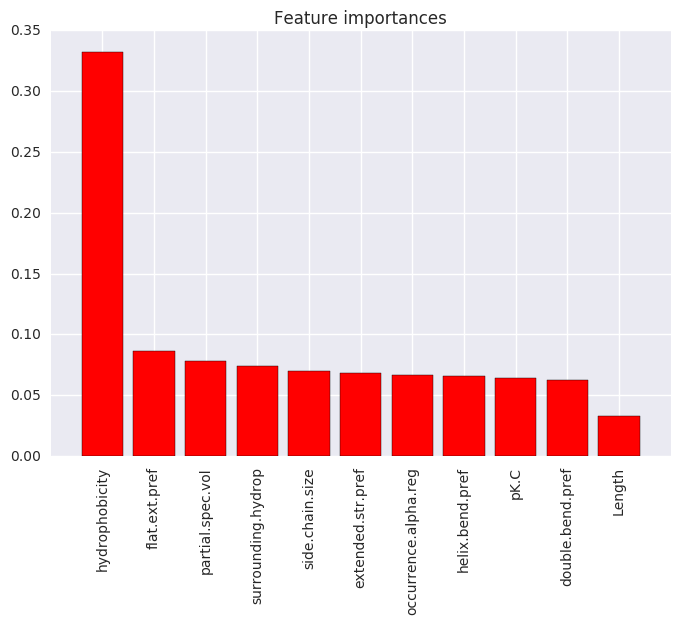

In [27]:
f, ax = plt.subplots()
plt.title("Feature importances")
plt.bar(range(len(feats_imp)), feats_imp['Importance'],
       color="r", align="center")
plt.xticks(range(len(feats_imp)), feats_imp.index, rotation='vertical')
plt.xlim([-1, 11])
plt.show()

In [28]:
knn = KNeighborsClassifier(n_neighbors=10)
dectree = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
extree = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2)
grboost = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1)
#mlp = MLPClassifier(random_state=42)
svclf = SVC(random_state=42)
gpc = GaussianProcessClassifier()
clfs = [knn, dectree, extree, grboost, svclf, gpc, forest]
cv = StratifiedKFold(n_splits=10)
for clf in clfs:
    print(type(clf).__name__, np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)))

KNeighborsClassifier 0.779802030941
DecisionTreeClassifier 0.680741806226
ExtraTreesClassifier 0.807408936869
GradientBoostingClassifier 0.771096755868
SVC 0.812646933688
GaussianProcessClassifier 0.82070563075
RandomForestClassifier 0.826990328389


In [29]:
def update_features():
    return ["Length","helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]

cv = StratifiedKFold(n_splits=10)

In [38]:
for feature in features:
    feats = update_features()
    feats.remove(feature)
    X_train = idf[feats].iloc[train_index,:]
    y_train = idf["Immunogenicity"].iloc[train_index]
    X_test = idf[feats].iloc[test_index,:]
    y_test = idf["Immunogenicity"].iloc[test_index]
    print("Without {0} model roc auc is {1:^10.3}".format(feature,\
          np.mean(cross_val_score(forest, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1))))

Without Length model roc auc is   0.825   
Without helix.bend.pref model roc auc is   0.827   
Without side.chain.size model roc auc is   0.822   
Without extended.str.pref model roc auc is   0.826   
Without hydrophobicity model roc auc is   0.757   
Without double.bend.pref model roc auc is   0.826   
Without partial.spec.vol model roc auc is    0.82   
Without flat.ext.pref model roc auc is   0.817   
Without occurrence.alpha.reg model roc auc is   0.825   
Without pK.C model roc auc is   0.825   
Without surrounding.hydrop model roc auc is   0.824   


In [119]:
def validation_curve(param):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_acc = []
    test_acc = []
    temp_train_acc = []
    temp_test_acc = []
    key = list(param.keys())[0]

    for ntrees in param[key]:
        pars = {key:ntrees}
        rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, **pars)
        temp_train_acc = []
        temp_test_acc = []
        X, y = idf[features], idf["Immunogenicity"]
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            rfc.fit(X_train, y_train)
            temp_train_acc.append(rfc.score(X_train, y_train))
            temp_test_acc.append(rfc.score(X_test, y_test))
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)

    train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
    print("Best accuracy on CV is {:.2f}% with {} {}".format(max(test_acc.mean(axis=1))*100, 
                                                            param[key][np.argmax(test_acc.mean(axis=1))], key))

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(param[key], train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
    ax.plot(param[key], test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
    ax.fill_between(param[key], test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(param[key], test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
    ax.legend(loc='best')
    # ax.set_ylim([0.88,1.02])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(key)

Best accuracy on CV is 75.96% with 67 trees


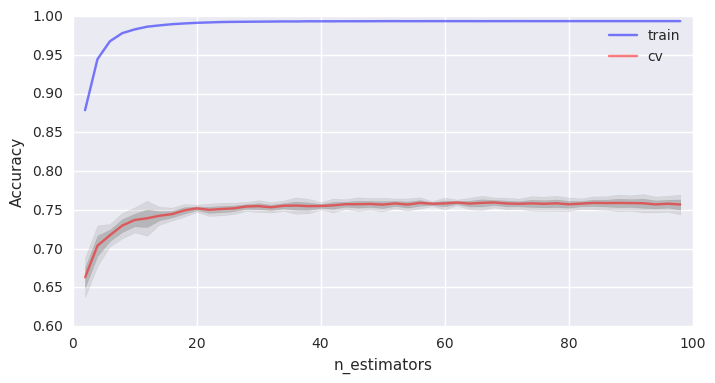

In [114]:
validation_curve({"n_estimators": np.arange(2,100,2)})

Best accuracy on CV is 73.92% with 3 min_samples_split


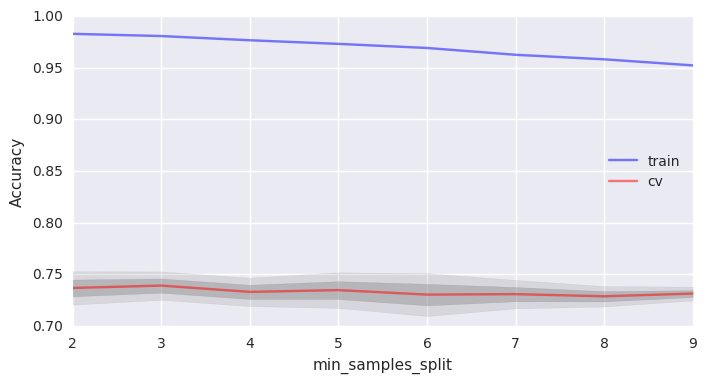

In [122]:
validation_curve({"min_samples_split": np.arange(2,10)})

Best accuracy on CV is 73.71% with 4 min_samples_leaf


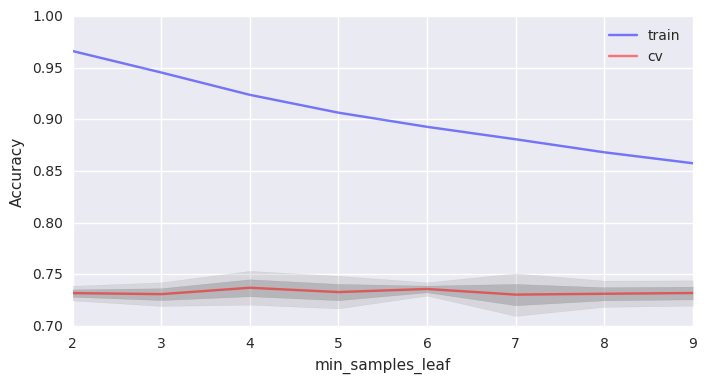

In [123]:
validation_curve({"min_samples_leaf": np.arange(2,10)})

Best accuracy on CV is 69.39% with 8 max_leaf_nodes


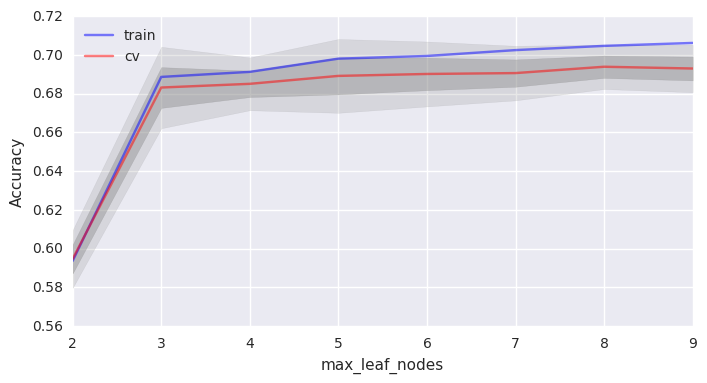

In [124]:
validation_curve({"max_leaf_nodes": np.arange(2,10)})

Best accuracy on CV is 73.70% with 0 min_impurity_decrease


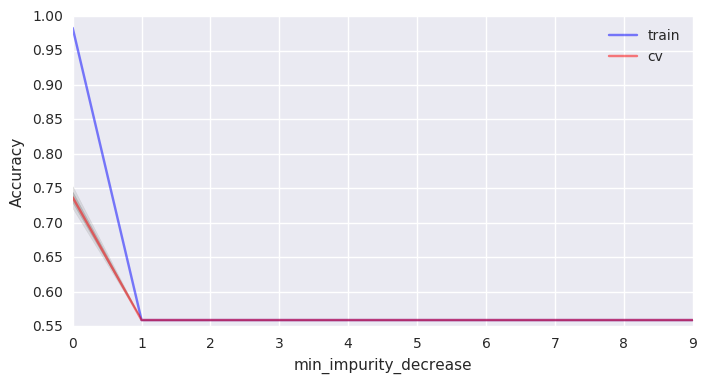

In [121]:
validation_curve({"min_impurity_decrease": np.arange(0,10)})

Best accuracy on CV is 74.01% with 6 max_features


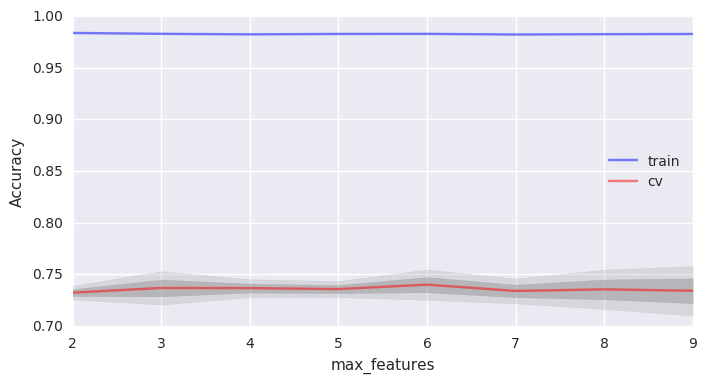

In [126]:
validation_curve({"max_features": np.arange(2,10)})

In [125]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [153]:
forest = RandomForestClassifier(max_features=6, min_samples_leaf=4, \
                                min_samples_split=3, n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
forest.fit(X_train, y_train)
extree = ExtraTreesClassifier(bootstrap=True, max_features=6, min_samples_leaf=4, \
                                min_samples_split=3, n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
extree.fit(X_train, y_train)
forest.oob_score_, extree.oob_score_

(0.75417471316596618, 0.74769964784732479)

In [138]:
forest1 = RandomForestClassifier(max_features=None, n_estimators=100, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1, oob_score=True)
forest1.fit(X_train, y_train)
parameters = {'max_depth': None, 'criterion': 'entropy', 'min_samples_leaf': 6,\
              'max_features': None, 'min_samples_split': 8, 'max_leaf_nodes': 9, 'n_estimators': 100}
forest2 = RandomForestClassifier(n_jobs=-1, oob_score=True, **parameters)
forest2.fit(X_train, y_train)
extree1 = ExtraTreesClassifier(max_features=None, n_estimators=100, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1)
extree1.fit(X_train, y_train)
forest1.oob_score_, forest2.oob_score_

(0.752470748608429, 0.70067022605929796)

In [152]:
clfs = [forest, extree, forest1, forest2, extree1]
cv = StratifiedKFold(n_splits=10)
for clf in clfs:
    print(type(clf).__name__, np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)))

RandomForestClassifier 0.821731532006
ExtraTreesClassifier 0.811619742799
RandomForestClassifier 0.822126555115
RandomForestClassifier 0.768535943614
ExtraTreesClassifier 0.824424717438


In [51]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])

0.7626977712846974

In [155]:
from sklearn.metrics import classification_report

target_names = ['Non-immunogenic', 'Immunogenic']
print(classification_report(y_test, forest1.predict(X_test), target_names=target_names))

                 precision    recall  f1-score   support

Non-immunogenic       0.73      0.71      0.72       970
    Immunogenic       0.78      0.79      0.79      1229

    avg / total       0.76      0.76      0.76      2199



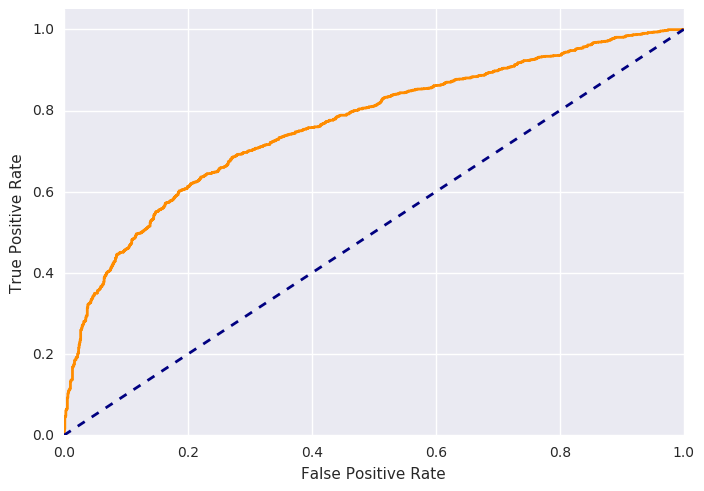

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [53]:
pdf = pd.read_csv("data/epitopes.csv")
pdf.head()

,allele,seq_num,start,end,length,peptide,method,percentile_rank,ann_ic50,ann_rank,smm_ic50,smm_rank,comblib_sidney2008_score,comblib_sidney2008_rank,netmhcpan_ic50,netmhcpan_rank,imm_score
0,HLA-A*02:01,173,25,38,14,YSYGGTVNLFWYVQ,ann,0.5,507.43,0.5,-,-,-,-,-,-,0.47031
1,HLA-A*02:01,173,26,38,13,SYGGTVNLFWYVQ,ann,0.9,871.62,0.9,-,-,-,-,-,-,0.44951
2,HLA-A*02:01,101,99,111,13,NNLFFGTGTRLTV,ann,0.8,711.63,0.8,-,-,-,-,-,-,0.43184
3,HLA-A*02:01,145,100,112,13,NNLFFGTGTRLTV,ann,0.8,711.63,0.8,-,-,-,-,-,-,0.43184
4,HLA-A*02:01,165,99,111,13,NNLFFGTGTRLTV,ann,0.8,711.63,0.8,-,-,-,-,-,-,0.43184


In [57]:
pdf1 = pdf[['peptide', 'length']]
pdf1.columns = ['Peptide', 'Length']
pdf2 = pdf1.Peptide.apply(lambda s: score_sequence(s))
pdf3 = pd.concat([pdf1, pdf2], axis=1)
pdf3 = pdf3.reset_index(drop=True)
pdf3.columns = ['Peptide', 'Length'] + features[1:]
pdf3.head()

,Peptide,Length,helix.bend.pref,side.chain.size,extended.str.pref,hydrophobicity,double.bend.pref,partial.spec.vol,flat.ext.pref,occurrence.alpha.reg,pK.C,surrounding.hydrop
0,YSYGGTVNLFWYVQ,14,0.455000,0.040714,0.430000,-0.281429,0.048571,-0.387857,-0.012857,0.435000,-0.356429,-0.028571
1,SYGGTVNLFWYVQ,13,0.383846,-0.070000,0.401538,-0.260000,0.052308,-0.365385,0.010000,0.389231,-0.380000,-0.071538
2,NNLFFGTGTRLTV,13,0.227692,-0.280000,0.395385,-0.030769,-0.123077,-0.378462,0.483846,0.313846,0.099231,0.045385
3,NNLFFGTGTRLTV,13,0.227692,-0.280000,0.395385,-0.030769,-0.123077,-0.378462,0.483846,0.313846,0.099231,0.045385
4,NNLFFGTGTRLTV,13,0.227692,-0.280000,0.395385,-0.030769,-0.123077,-0.378462,0.483846,0.313846,0.099231,0.045385


In [64]:
proba = forest.predict_proba(pdf3[features])[:, 1]

In [66]:
pdf['imm_proba'] = proba

In [67]:
pdf.to_csv("output/epitopes_proc.txt", index=False)

In [ ]:
from scipy.stats import pearsonr
